EDA guide: https://miykael.github.io/blog/2022/advanced_eda/

# EDA Analysis

## Imported files

In [658]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

Now that we know we have **45 floats** and **2 datetime** types, can display which features we have.

## Investigation of the data structure

It can be wise to investigate the dataset and visualize how it is structured.

/var/folders/y3/2mtrz03n77j2nhqjpj_67ptm0000gn/T/ipykernel_1378/3053554035.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time'] = pd.to_datetime(df_filtered['time'])


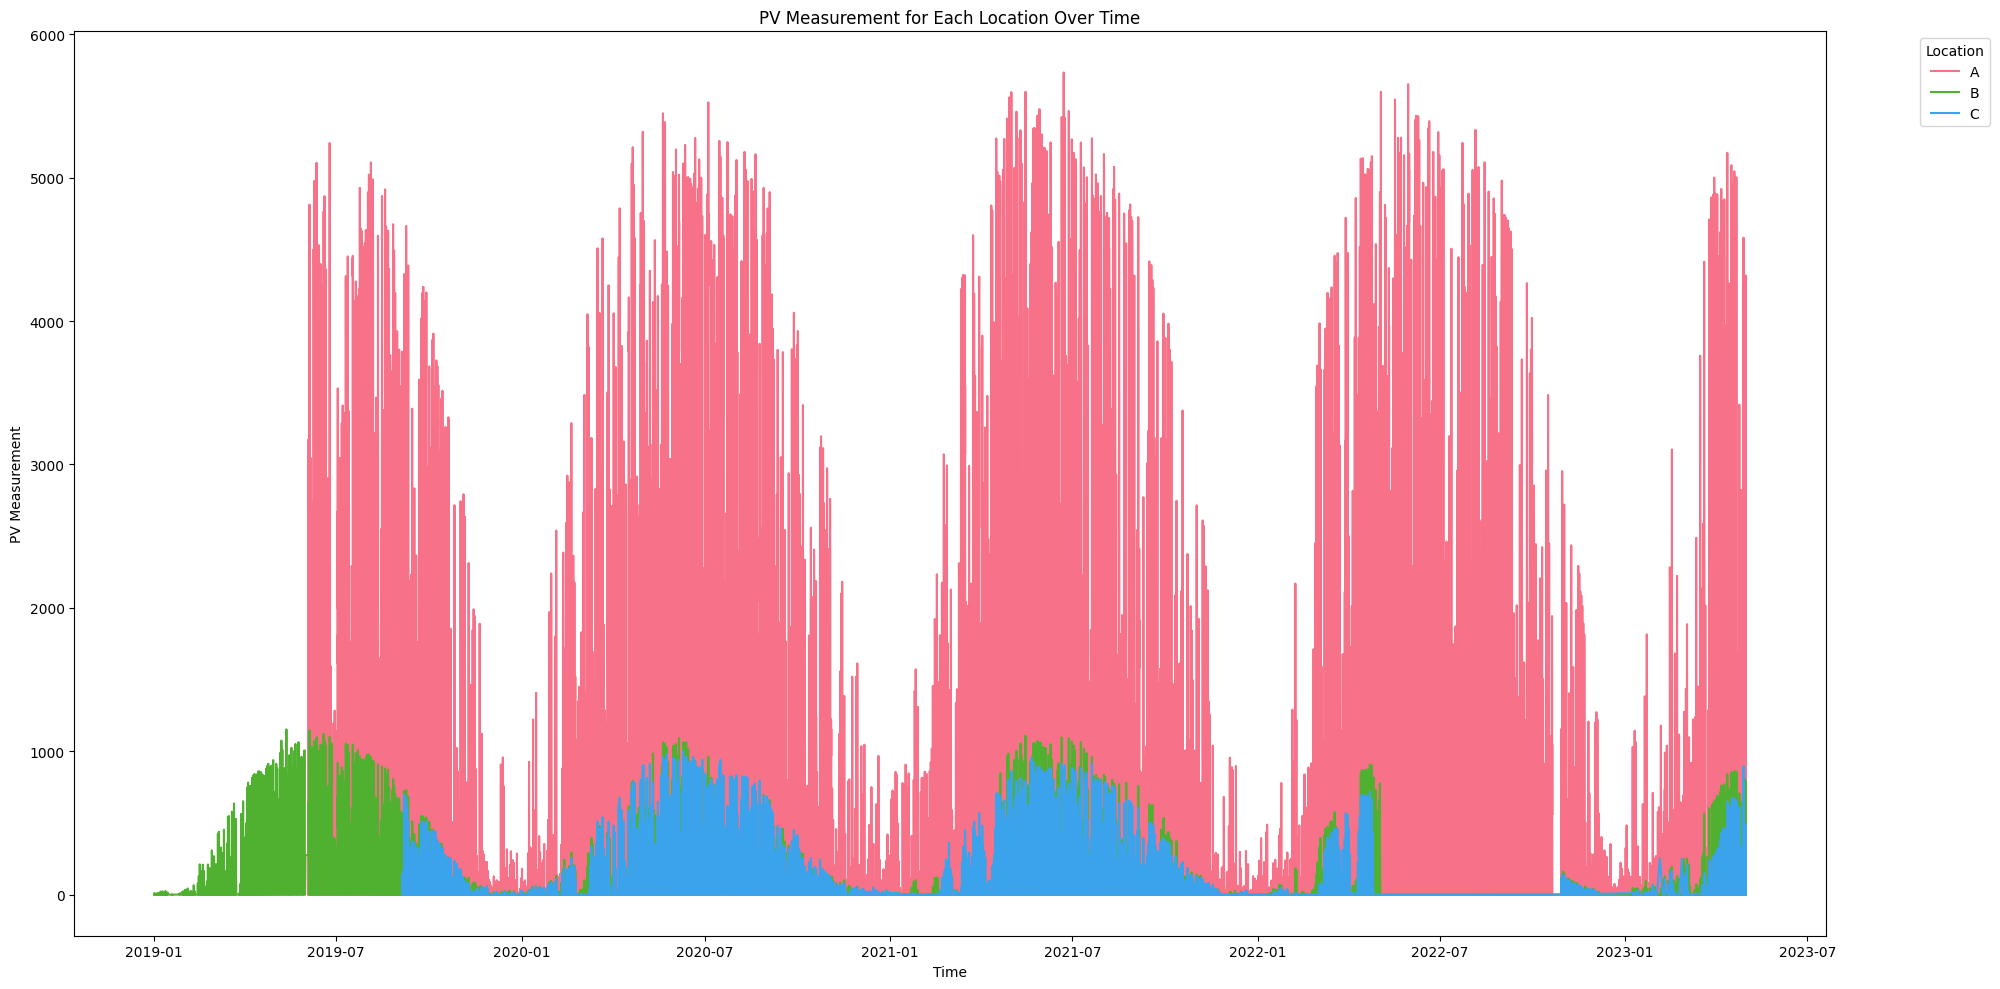

In [659]:
# Read the CSV file
df = pd.read_csv('all_locations.csv')  # Replace with the path to your CSV file

# Filter relevant columns
df_filtered = df[['time', 'pv_measurement', 'location']]

# Convert 'time' column to datetime format for plotting
df_filtered['time'] = pd.to_datetime(df_filtered['time'])

# Define a color palette for better differentiation between locations
palette = sns.color_palette("husl", len(df_filtered['location'].unique()))

# Plot the data
plt.figure(figsize=(20, 10))
sns.lineplot(x='time', y='pv_measurement', hue='location', data=df_filtered, palette=palette)
plt.title('PV Measurement for Each Location Over Time')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Observations: PV measurement follows an intuitive yearly cycle
We can observe that the data from A, B and C distributions follow an intuitive time series, where the PV measurements are higher during the summer months and lower during the winter months.

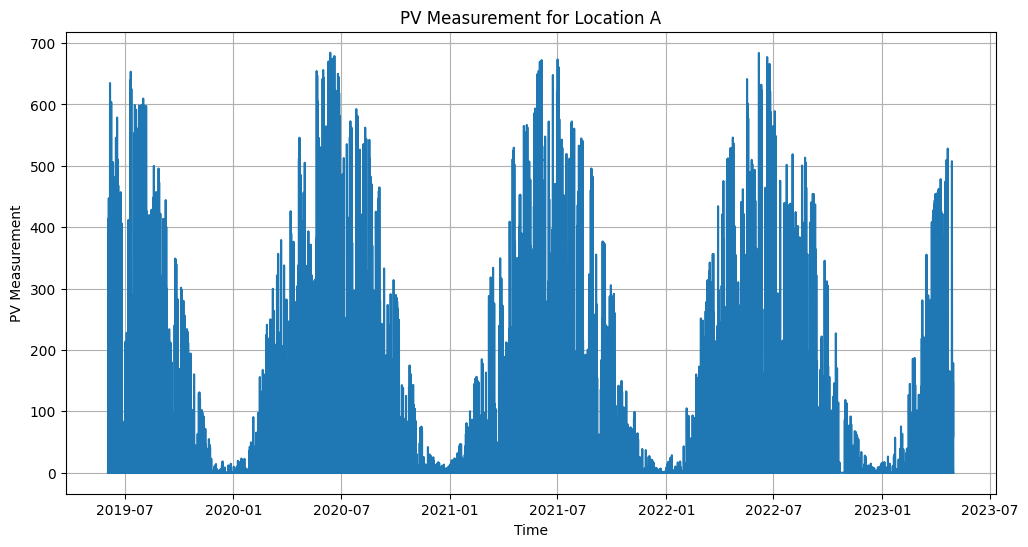

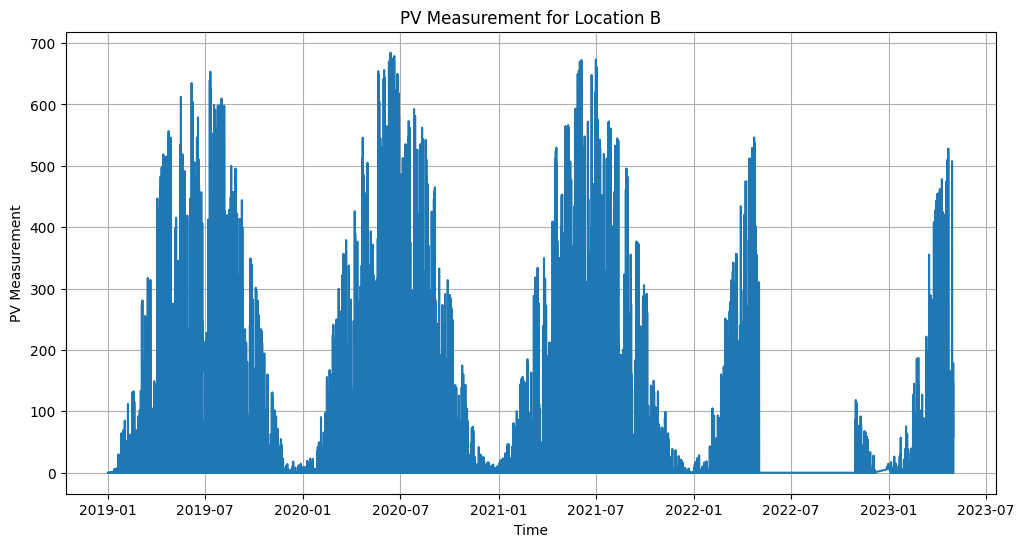

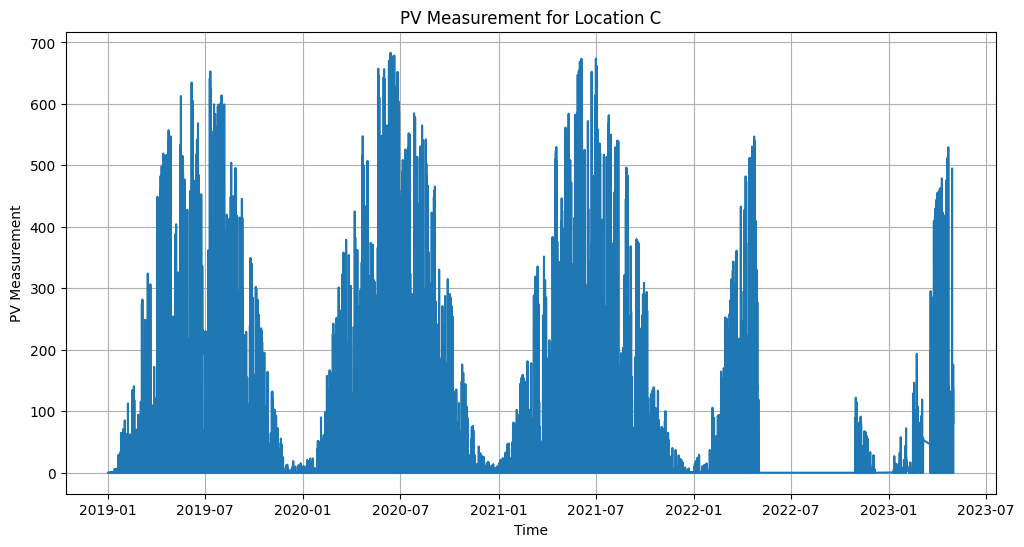

In [660]:
# Identify unique locations in the dataset
unique_locations = df['location'].unique()

# Loop through each unique location to plot the data
for loc in unique_locations:
    # Filter the data for the current location
    df_filtered = df[df['location'] == loc]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(df_filtered['time']), df_filtered['direct_rad:W'])

    # Customize the plot
    plt.title(f'PV Measurement for Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.grid(True)

    # Show the plot
    plt.show()


First we look at the target variable across each of the locations. As we see, location A looks to be quite good, but B and C may have some major problems in the time series. We will look at the data in more detail to see if we can find any problems. First we look at location A.

----
## NOTES: FIND THE MISSING VALUES IN B AND C.
### COULD BE DONE BY:
Decompose the time series of location A into trend, seasonal, and residual components.
Fit an ARIMA model on the decomposed series.
Predict the missing values for location C using the model and the scaling factor between locations A and C. 

### COULD BE DONE BY:
USE A XGBOOST MODEL TRAINED ON A AND SCALE THE PREDICTIONS FOR B AND C. 

### COULD BE DONE BY:
CALCULATING THE AVERAGE SCALING FACTOR BETWEEN A AND B & C: FILL THE MISSING VALUE BASED ON THIS. 

### COULD BE DONE BY:
HANDLE THIS AS A NORMAL REGRESSION PROBLEM AND REMOVE ROWS WITH MISSING VALUES. 

----

It can be wise to investigate the dataset and visualize how it is structured.

In [661]:
# Size of the dataset
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

print()

# Count how mnay times each datatype appears
print("Data types: ")
print(df.dtypes.value_counts())

print()

# Display all non-time features
print("All float features: ")
print(df.select_dtypes(include=['float32']).columns)

# Display all time features
print("All date time features: ")
print(df.select_dtypes(include=['datetime64[ns]']).columns)

Number of rows:  99014
Number of columns:  46

Data types: 
float64    43
object      2
int64       1
Name: count, dtype: int64

All float features: 
Index([], dtype='object')
All date time features: 
Index([], dtype='object')


# Location A

In [662]:
# Read the CSV files
train_targets = pd.read_parquet('./data/A/train_targets.parquet')
X_test_estimated = pd.read_parquet('./data/A/X_test_estimated.parquet')
X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')

We start by describing the data we want to explore.

In [663]:
# Describe the training targets
X_test_estimated.describe().T

,count,mean,min,25%,50%,75%,max,std
date_calc,2880,2023-06-04 17:24:20.700000,2023-04-30 07:00:04,2023-05-22 07:00:04,2023-06-02 19:00:22,2023-06-18 07:00:05,2023-07-02 07:00:31,NaN
date_forecast,2880,2023-06-05 22:16:30,2023-05-01 00:00:00,2023-05-23 11:56:15,2023-06-03 23:52:30,2023-06-19 11:48:45,2023-07-03 23:45:00,NaN
absolute_humidity_2m:gm3,2880.0,8.205903,3.2,6.7,8.1,10.0,13.8,2.179117
air_density_2m:kgm3,2880.0,1.23315,1.151,1.209,1.2385,1.26,1.3,0.032109
ceiling_height_agl:m,2087.0,3061.526611,53.299999,954.099976,1664.300049,4082.700195,11443.900391,2936.846924
clear_sky_energy_1h:J,2880.0,1227651.25,0.0,54776.375977,1046824.5625,2355268.5625,3005374.75,1104096.5
clear_sky_rad:W,2880.0,341.014008,0.0,14.325,290.5,655.350006,836.299988,307.64325
cloud_base_agl:m,2582.0,1866.812988,30.200001,509.100006,1048.0,2394.5,11256.700195,2108.218262
dew_or_rime:idx,2880.0,0.034722,0.0,0.0,0.0,0.0,1.0,0.183107
dew_point_2m:K,2880.0,280.800171,268.100006,278.0,281.100006,284.399994,289.700012,4.340125


In [664]:
X_train_observed.describe().T

,count,mean,min,25%,50%,75%,max,std
date_forecast,118669,2021-02-09 23:30:00,2019-06-02 22:00:00,2020-04-06 22:45:00,2021-02-09 23:30:00,2021-12-16 00:15:00,2022-10-21 01:00:00,NaN
absolute_humidity_2m:gm3,118669.0,6.652576,0.7,4.4,6.3,8.6,17.5,2.796349
air_density_2m:kgm3,118669.0,1.249064,1.145,1.224,1.247,1.272,1.427,0.036319
ceiling_height_agl:m,96422.0,2907.949219,27.799999,1102.900024,1882.400024,3969.75,12328.5,2570.413086
clear_sky_energy_1h:J,118669.0,599401.75,0.0,0.0,35747.699219,1037818.8125,3005720.25,879542.3125
clear_sky_rad:W,118669.0,166.500381,0.0,0.0,8.6,288.799988,836.400024,244.945358
cloud_base_agl:m,110603.0,1737.142212,27.9,590.700012,1162.599976,2079.600098,11688.700195,1815.584106
dew_or_rime:idx,118669.0,0.022398,-1.0,0.0,0.0,0.0,1.0,0.190367
dew_point_2m:K,118669.0,276.823395,250.899994,272.100006,277.200012,282.0,293.799988,6.701763
diffuse_rad:W,118669.0,44.918282,0.0,0.0,4.1,76.0,345.700012,64.786697


In [665]:
X_train_estimated.describe().T

,count,mean,min,25%,50%,75%,max,std
date_calc,17576,2023-01-27 19:07:13.160673,2022-10-27 07:00:18,2022-12-12 08:00:05,2023-01-28 08:00:04,2023-03-15 08:00:04,2023-04-29 07:00:05,NaN
date_forecast,17576,2023-01-28 23:11:50.127446,2022-10-28 22:00:00,2022-12-13 16:26:15,2023-01-29 10:52:30,2023-03-16 05:18:45,2023-04-30 23:45:00,NaN
absolute_humidity_2m:gm3,17576.0,4.092438,1.0,3.0,3.9,5.1,8.8,1.51115
air_density_2m:kgm3,17576.0,1.281746,1.212,1.262,1.279,1.301,1.374,0.03005
ceiling_height_agl:m,13657.0,3257.459473,27.9,1185.5,2750.0,4775.5,12307.700195,2501.79834
clear_sky_energy_1h:J,17576.0,237126.34375,0.0,0.0,0.0,137487.355469,2555980.0,517343.46875
clear_sky_rad:W,17576.0,65.868149,0.0,0.0,0.0,37.400002,711.599976,144.162888
cloud_base_agl:m,15482.0,1575.233032,27.799999,497.524994,935.75,1919.599976,10813.700195,1718.795166
dew_or_rime:idx,17576.0,0.00899,-1.0,0.0,0.0,0.0,1.0,0.22154
dew_point_2m:K,17576.0,270.222351,254.699997,266.799988,270.399994,273.899994,282.100006,5.215952


In [666]:
train_targets.describe().T

,count,mean,min,25%,50%,75%,max,std
time,34085,2021-05-14 00:29:51.497726,2019-06-02 22:00:00,2020-05-22 23:00:00,2021-05-13 00:00:00,2022-05-03 01:00:00,2023-04-30 23:00:00,NaN
pv_measurement,34085.0,630.594707,0.0,0.0,5.94,678.04,5733.42,1165.902422


### Observations
We get some immediate observations when looking at he results above. We can observe that some features show a considerable difference between their maximum and 75% percentile values, suggesting the possible presence of outliers. for example ceiling_height_agl:m has max value of 11468.0 while the while the 75th percentile is at 3923.899902 meters. This extremely high values differences could indicate that it might be some outliers in the data.

From these to descriptions we can see that X_train_observed stops where X_train_estimated start. This gives us an intuition to concat the two datasets.

We also see that the date_forecast feature contains values for each quarter of an hour. This needs to be fixed since train_targets only contain values for each hour.

In [667]:
df_A = pd.concat([X_train_observed, X_train_estimated])

In [668]:
df_A = pd.merge(df_A, train_targets, left_on='date_forecast', right_on='time', how='inner')

Merging the train_targets into df_A to make it easier with analysis later on. This also removed each value not containing a whole hour, cleaning up a little bit.

## 1. Datatypes and structure
It can be wise to investigate the dataset and visualize how it is structured.

## 1.1 Non-numeric features

In [669]:
df_A.select_dtypes(exclude='number').head()

,date_forecast,date_calc,time
0,2019-06-02 22:00:00,NaT,2019-06-02 22:00:00
1,2019-06-02 23:00:00,NaT,2019-06-02 23:00:00
2,2019-06-03 00:00:00,NaT,2019-06-03 00:00:00
3,2019-06-03 01:00:00,NaT,2019-06-03 01:00:00
4,2019-06-03 02:00:00,NaT,2019-06-03 02:00:00


From this we can extract two major points of information: 
- First of all, we have 24hrs of data for just about each day in the dataset. 
- Secondly, after merging the X_train_observed, X_train_estimated and train_targets we now have these three datetime columns. From this we see: date_calc contain NaT values, date_forecast and time has the same values. These findings indicate that we can remove either time or date_forecast and have to look deeper into date_calc.

In [670]:
df_A['date_calc'].describe()

count                          4394
mean     2023-01-27 19:07:13.160673
min             2022-10-27 07:00:18
25%             2022-12-12 08:00:05
50%             2023-01-28 08:00:04
75%             2023-03-15 08:00:04
max             2023-04-29 07:00:05
Name: date_calc, dtype: object

When describing the feature we can see that it has values for almost a year. This may indicate that something went wrong when either concating or merging the datasets. Let's investigate:

In [671]:
X_train_estimated[['date_forecast', 'date_calc']].head()

,date_forecast,date_calc
0,2022-10-28 22:00:00,2022-10-27 07:00:18
1,2022-10-28 22:15:00,2022-10-27 07:00:18
2,2022-10-28 22:30:00,2022-10-27 07:00:18
3,2022-10-28 22:45:00,2022-10-27 07:00:18
4,2022-10-28 23:00:00,2022-10-27 07:00:18


From this we can see that date_calc indicates which day a forecast was calculated. Based on this, we can for now safely remove it.

In [672]:
df_A = df_A.drop(columns=['date_calc', 'date_forecast'])
df_A.select_dtypes(exclude='number').head()

,time
0,2019-06-02 22:00:00
1,2019-06-02 23:00:00
2,2019-06-03 00:00:00
3,2019-06-03 01:00:00
4,2019-06-03 02:00:00


In [673]:
df_A.describe(exclude='number')

,time
count,34061
mean,2021-05-13 13:58:16.843897
min,2019-06-02 22:00:00
25%,2020-05-22 17:00:00
50%,2021-05-12 12:00:00
75%,2022-05-02 07:00:00
max,2023-04-30 23:00:00


We have a total of 34061 rows of data, ranging from the mid of June 2019 to the mid of April 2023

## 1.2 Numeric features

<Axes: >

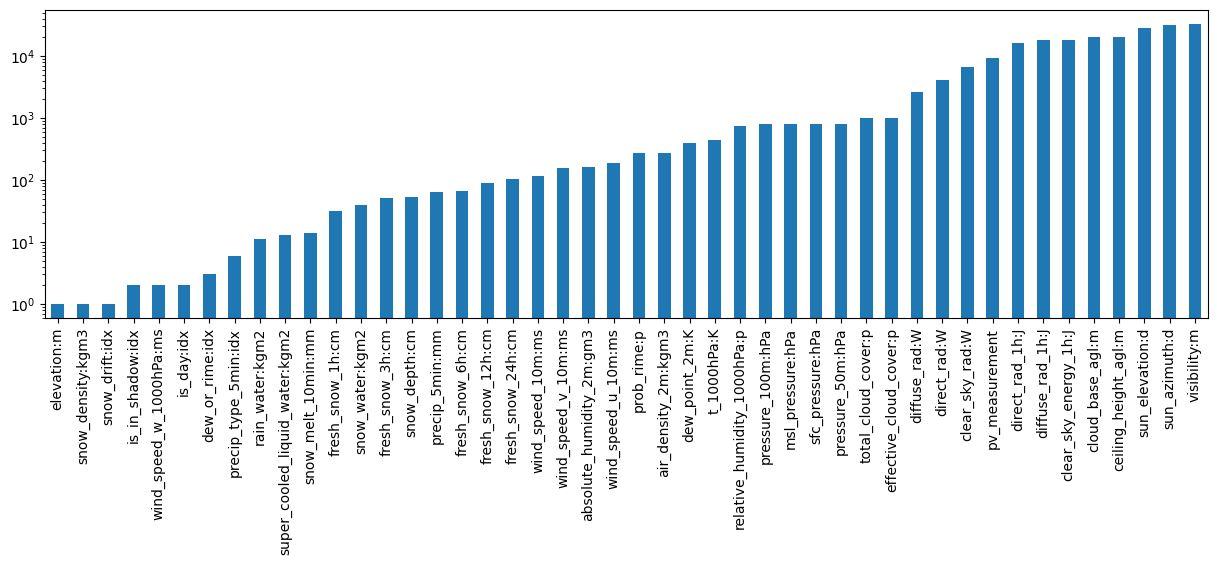

In [674]:
unique_values = df_A.select_dtypes(exclude='datetime').nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4))

From this we can see that most features are continuous, but three of the features are single valued. This means that they only have one value across all rows. This is something we need to investigate further:

In [675]:
df_A[['elevation:m', 'snow_density:kgm3', 'snow_drift:idx']].head(30)

,elevation:m,snow_density:kgm3,snow_drift:idx
0,6.0,NaN,0.0
1,6.0,NaN,0.0
2,6.0,NaN,0.0
3,6.0,NaN,0.0
4,6.0,NaN,0.0
5,6.0,NaN,0.0
6,6.0,NaN,0.0
7,6.0,NaN,0.0
8,6.0,NaN,0.0
9,6.0,NaN,0.0


These features have major issues and can therefor be removed from the dataset

In [676]:
df_A = df_A.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx'], axis=1)
pd.value_counts(df_A.dtypes)

/var/folders/y3/2mtrz03n77j2nhqjpj_67ptm0000gn/T/ipykernel_1378/3858015291.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_A.dtypes)


float32           42
datetime64[us]     1
float64            1
Name: count, dtype: int64

As we can see, we now have three less float32 features, meaning that the features was properly removed.

# 2. Quality check

In [677]:
df_A.isna().sum()

absolute_humidity_2m:gm3             0
air_density_2m:kgm3                  0
ceiling_height_agl:m              7777
clear_sky_energy_1h:J                0
clear_sky_rad:W                      0
cloud_base_agl:m                  3063
dew_or_rime:idx                      0
dew_point_2m:K                       0
diffuse_rad:W                        0
diffuse_rad_1h:J                     0
direct_rad:W                         0
direct_rad_1h:J                      0
effective_cloud_cover:p              0
fresh_snow_12h:cm                    0
fresh_snow_1h:cm                     0
fresh_snow_24h:cm                    0
fresh_snow_3h:cm                     0
fresh_snow_6h:cm                     0
is_day:idx                           0
is_in_shadow:idx                     0
msl_pressure:hPa                     0
precip_5min:mm                       0
precip_type_5min:idx                 0
pressure_100m:hPa                    0
pressure_50m:hPa                     0
prob_rime:p              

In [678]:
missing_values = df_A.isna().sum()
missing_values = missing_values[missing_values > 0]
print(f'Number of features with missing values: {missing_values.shape[0]}')
print(f'Number of missing values per feature:')
print(missing_values)

Number of features with missing values: 2
Number of missing values per feature:
ceiling_height_agl:m    7777
cloud_base_agl:m        3063
dtype: int64


We have a total of 7777 missing values in ceiling_height_agl:m and 3063 missing values in cloud_base_agl:m. There are too many missing values to remove the rows containing them, and we don't know the importance of the features yet, so we can't just remove them. Our only choice is then to impute them. A normal strategy for numeric features is using the mean of this feature:

In [679]:
imputer = SimpleImputer(strategy='mean')
df_A[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(df_A[['ceiling_height_agl:m', 'cloud_base_agl:m']])

In [680]:
df_A.isna().sum()

absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                       0
rain_water:kgm2                   0
relative_humidity_1000hPa:p 

All the null values is now removed

# REMEMBER TO FIND OUTLIERS

# 3. Shallow Feature Information
Considering the dimensionality of the dataset, analyzing each feature independently is close to impossible. Therefor, we will first plot each feature and only comment those with some interesting values.

## 3.1 Feature Distributions

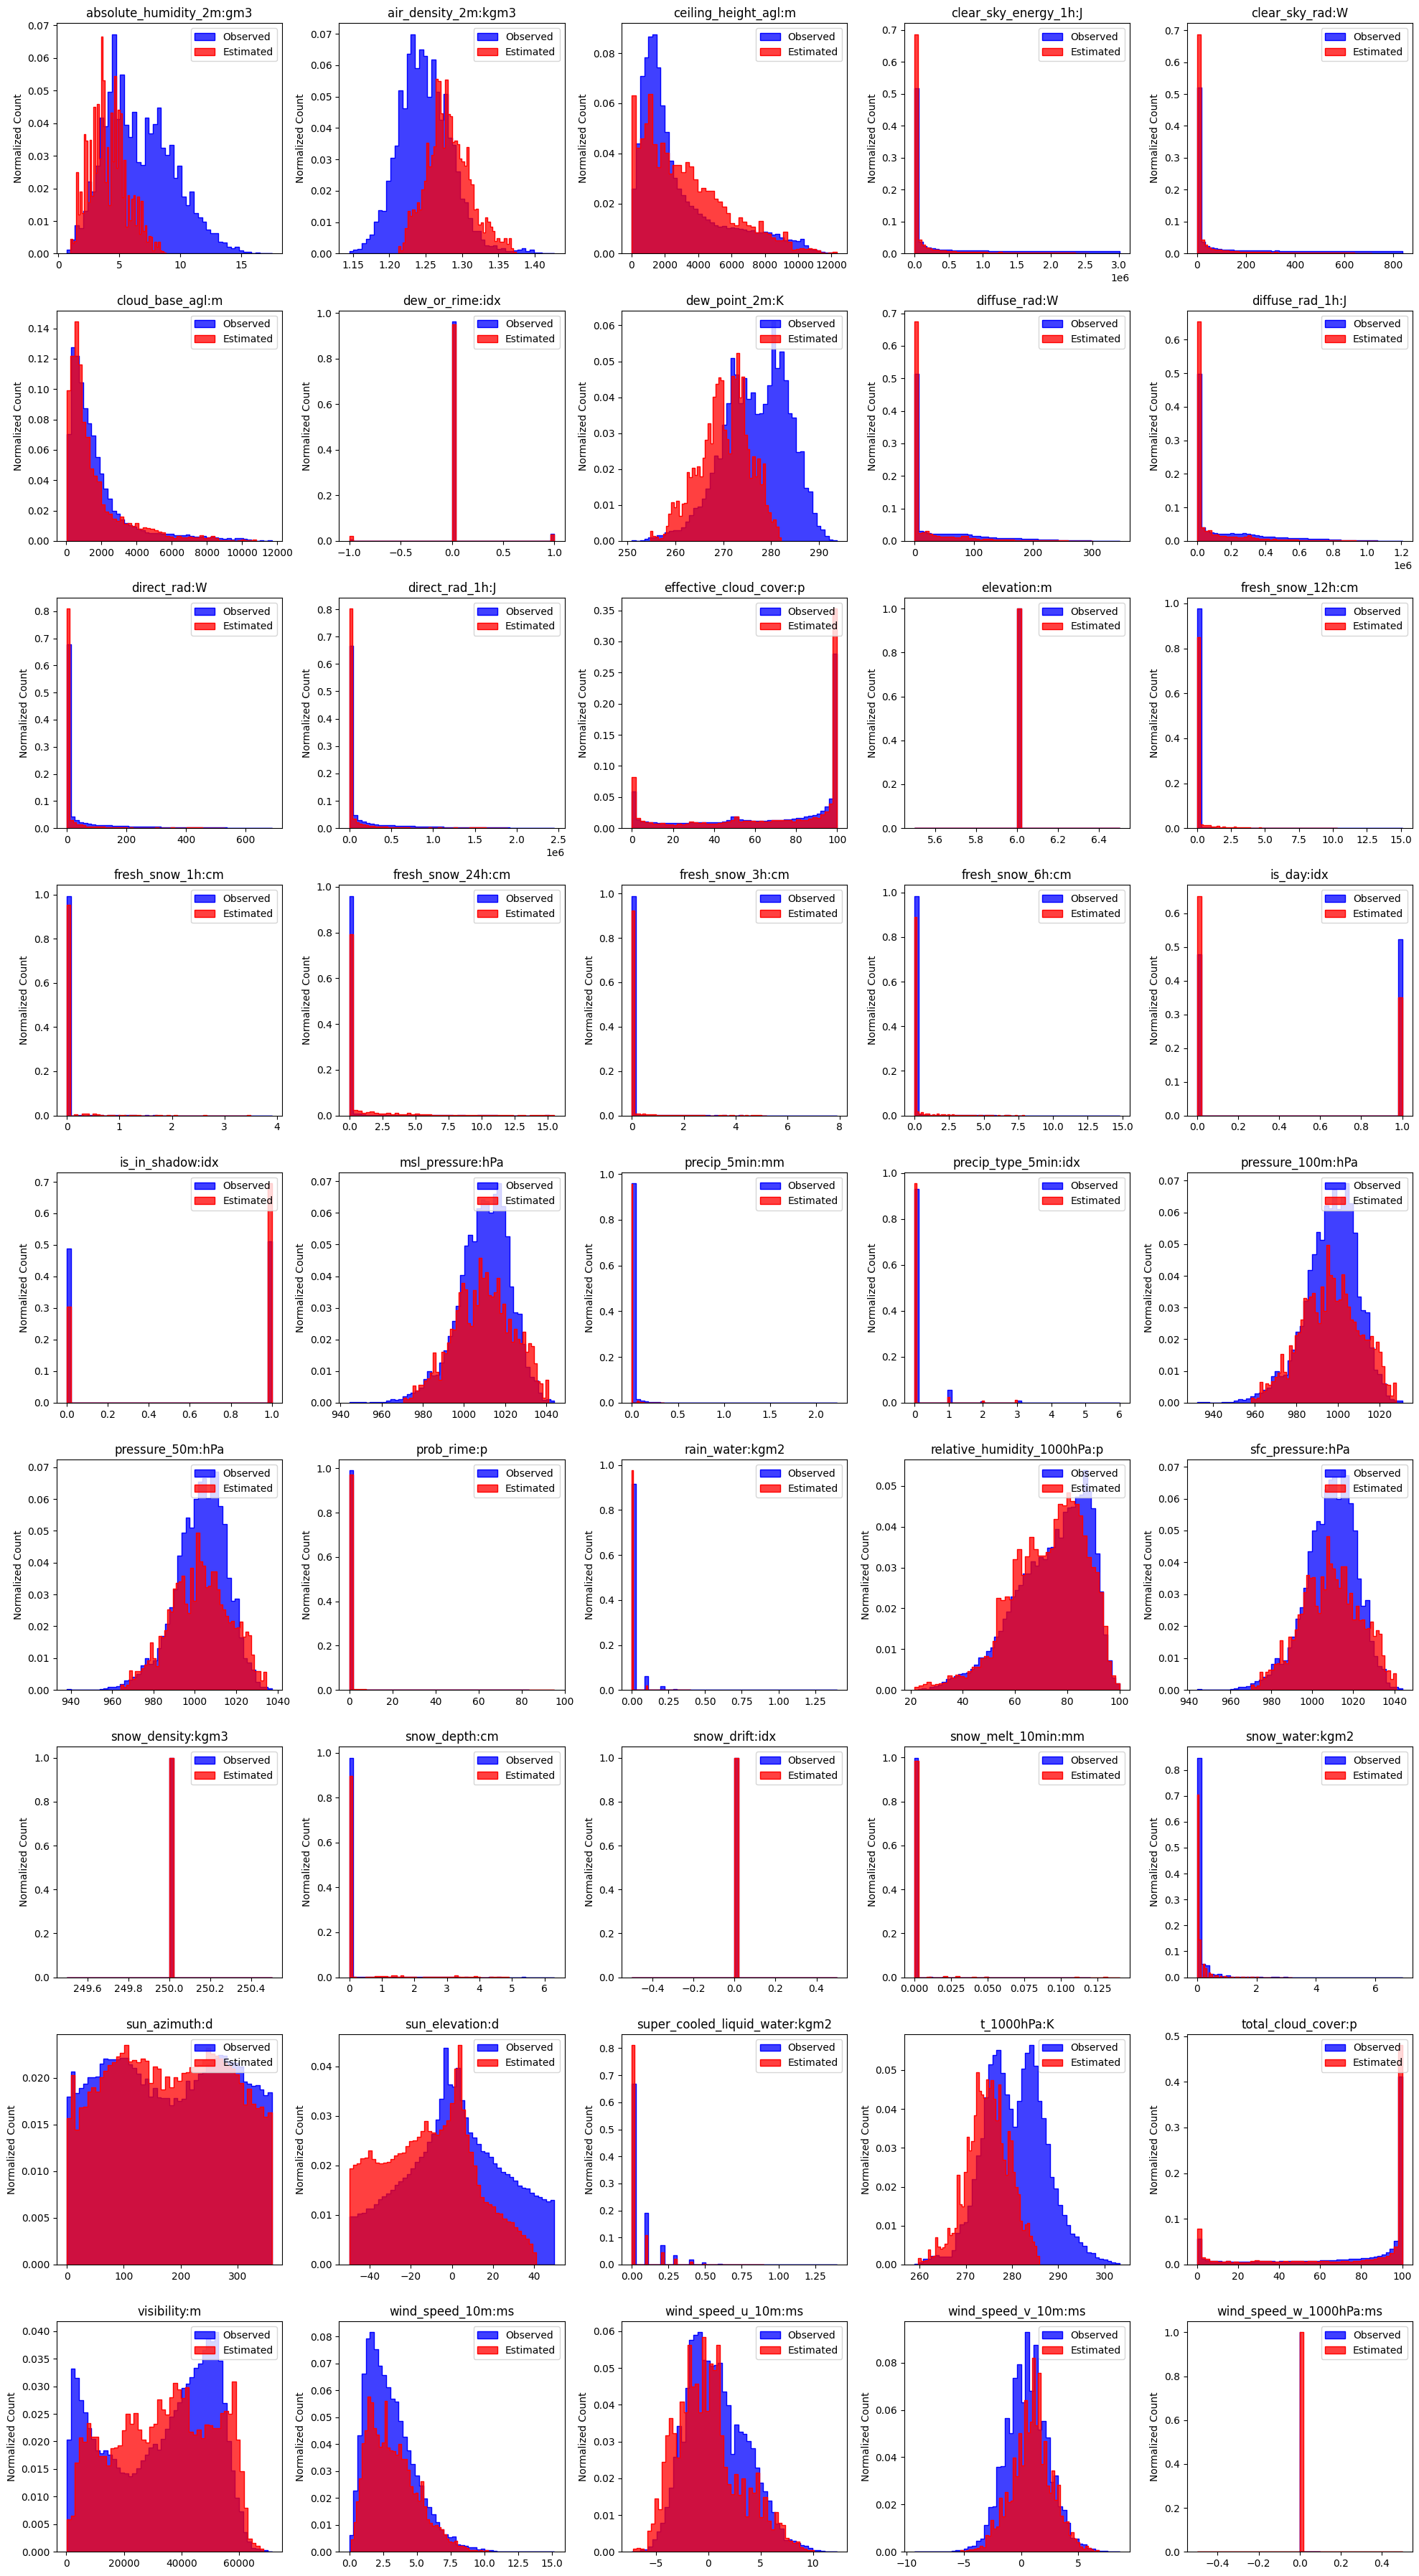

In [681]:
# Drop the index and target variable columns for feature distribution analysis
X_observed = X_train_observed.drop(columns=['date_forecast'])
X_estimated = X_train_estimated.drop(columns=['date_forecast'])
def plot_grid_feature_distributions(observed_df, estimated_df):
    features = observed_df.columns
    num_features = len(features)
    num_rows = -(-num_features // 5)  # Calculate rows needed, rounding up
    
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))
    axes = axes.flatten()  # Flatten the 2D array to 1D
    
    for i, feature in enumerate(features):
        ax = axes[i]
        sns.histplot(observed_df[feature], kde=False, bins=50, color='b', label='Observed', stat='probability', ax=ax, element='step')
        sns.histplot(estimated_df[feature], kde=False, bins=50, color='r', label='Estimated', stat='probability', ax=ax, element='step')
        ax.set_title(f'{feature}')
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Count')
        ax.legend()
    
    # Remove extra subplots
    for i in range(num_features, num_rows * 5):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the grid
plot_grid_feature_distributions(X_observed, X_estimated)

absolute_humidity_2m:gm3: Shows a bimodal distribution, indicating two distinct groups or conditions in the dataset.

air_density_2m:kgm3: Almost normally distributed but has some outliers on the lower end.

ceiling_height_agl:m: Highly skewed to the right, meaning most of the values are clustered at the lower end.

clear_sky_energy_1h:J: Most values are zero, but there are some with higher values, indicating specific conditions where clear sky energy is non-zero.

total_cloud_cover:p: The distribution is almost binary, with most values at either 0 or 100, indicating clear sky or full cloud cover.

visibility:m: This feature also shows a bimodal distribution, indicating two different visibility conditions.

pv_measurement: Highly skewed towards the left. Indicating, most of the time, the solar power consumption is very low.

## 3.2 Linear Correlations

In [682]:
cols_continuous = df_A.select_dtypes(include="number").nunique() >= 25
df_continuous = df_A[cols_continuous[cols_continuous].index]

# Find linear correlations between features and plot them
corr = df_continuous.corr()
corr.style.background_gradient(cmap='coolwarm')

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,msl_pressure:hPa,precip_5min:mm,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,pv_measurement
absolute_humidity_2m:gm3,1.000000,-0.810686,0.042662,0.365382,0.362499,0.018491,0.974333,0.295023,0.300849,0.244525,0.248517,0.033103,-0.146655,-0.086348,-0.181893,-0.104892,-0.121427,0.136145,0.074510,0.153836,0.142765,-0.054758,0.168657,0.131707,-0.208868,0.046732,0.023055,0.434021,0.906104,0.056134,-0.155764,-0.136678,0.085915,-0.247395,0.236673
air_density_2m:kgm3,-0.810686,1.000000,-0.100516,-0.474635,-0.464285,-0.096693,-0.844157,-0.404488,-0.417030,-0.385842,-0.400172,-0.088489,0.089939,0.057598,0.115126,0.068919,0.078043,0.287670,-0.086920,0.271122,0.283049,0.071140,0.114594,0.294898,0.276186,-0.079980,-0.060066,-0.498568,-0.914536,-0.120611,-0.006242,-0.036233,-0.011957,0.138931,-0.356402
ceiling_height_agl:m,0.042662,-0.100516,1.000000,0.062960,0.056180,0.630721,0.032787,0.077742,0.081299,0.179454,0.188034,-0.217263,-0.015193,-0.012134,-0.015334,-0.014852,-0.015866,0.046503,-0.009506,0.049373,0.047862,0.010451,-0.329921,0.046317,-0.028042,-0.171318,0.048920,0.054720,0.165983,0.023207,0.390849,-0.136340,-0.276853,0.014447,0.126655
clear_sky_energy_1h:J,0.365382,-0.474635,0.062960,1.000000,0.992402,0.049354,0.369643,0.913830,0.923424,0.727004,0.737647,-0.004292,-0.072468,-0.049978,-0.087835,-0.060337,-0.066895,0.151306,-0.007214,0.154326,0.148038,-0.052413,-0.326905,0.141757,-0.080756,-0.030771,0.036556,0.836855,0.443593,0.002292,0.080811,0.011237,0.075364,-0.337065,0.781216
clear_sky_rad:W,0.362499,-0.464285,0.056180,0.992402,1.000000,0.045576,0.366720,0.919982,0.915885,0.734266,0.733544,-0.003579,-0.070790,-0.049509,-0.087575,-0.059322,-0.065489,0.151954,-0.007818,0.154669,0.148529,-0.052068,-0.301336,0.142391,-0.080364,-0.032847,-0.015381,0.840429,0.429984,0.002388,0.072005,0.001758,0.070277,-0.322642,0.803538
cloud_base_agl:m,0.018491,-0.096693,0.630721,0.049354,0.045576,1.000000,0.008911,0.033952,0.037690,0.197413,0.204310,-0.253886,-0.029807,-0.020486,-0.026219,-0.026092,-0.029587,0.037853,-0.026546,0.040871,0.039417,0.016319,-0.399315,0.037924,-0.047556,-0.114431,0.041326,0.034649,0.170680,-0.039590,0.420764,-0.185376,-0.357859,0.049911,0.142908
dew_point_2m:K,0.974333,-0.844157,0.032787,0.369643,0.366720,0.008911,1.000000,0.302921,0.308791,0.245951,0.250140,0.071622,-0.152597,-0.091940,-0.189946,-0.110848,-0.127406,0.126397,0.073853,0.144653,0.133145,-0.049192,0.169242,0.121659,-0.271707,0.061332,0.024060,0.438644,0.922580,0.091577,-0.179793,-0.090881,0.127008,-0.233110,0.245950
diffuse_rad:W,0.295023,-0.404488,0.077742,0.913830,0.919982,0.033952,0.302921,1.000000,0.988889,0.566684,0.570769,0.067708,-0.057050,-0.048286,-0.068641,-0.055987,-0.058077,0.129463,-0.017210,0.131264,0.125951,-0.053260,-0.290519,0.120660,-0.063743,-0.075483,-0.014099,0.807621,0.357758,0.083719,0.095887,-0.000595,0.068413,-0.295301,0.702831
diffuse_rad_1h:J,0.300849,-0.417030,0.081299,0.923424,0.915885,0.037690,0.308791,0.988889,1.000000,0.566275,0.575267,0.063514,-0.059948,-0.049282,-0.069576,-0.058147,-0.060874,0.130063,-0.015618,0.132167,0.126678,-0.054300,-0.315131,0.121214,-0.064869,-0.068525,0.038874,0.807946,0.372659,0.078222,0.103230,0.006844,0.072680,-0.310672,0.687206
direct_rad:W,0.244525,-0.385842,0.179454,0.727004,0.734266,0.197413,0.245951,0.566684,0.566275,1.000000,0.987655,-0.329552,-0.054533,-0.036770,-0.068308,-0.044309,-0.049434,0.178937,-0.051716,0.179699,0.174534,-0.036559,-0.447796,0.169354,-0.054066,-0.144720,-0.014

We observe on the table above that clear_sky_energy_1h:J and clear_sky_rad:W have a very high correlation of approximately 0.99, indicating potential redundancy and linerarity. Let's investigate that with a correlation plot of these two.


<Axes: xlabel='clear_sky_energy_1h:J', ylabel='clear_sky_rad:W'>

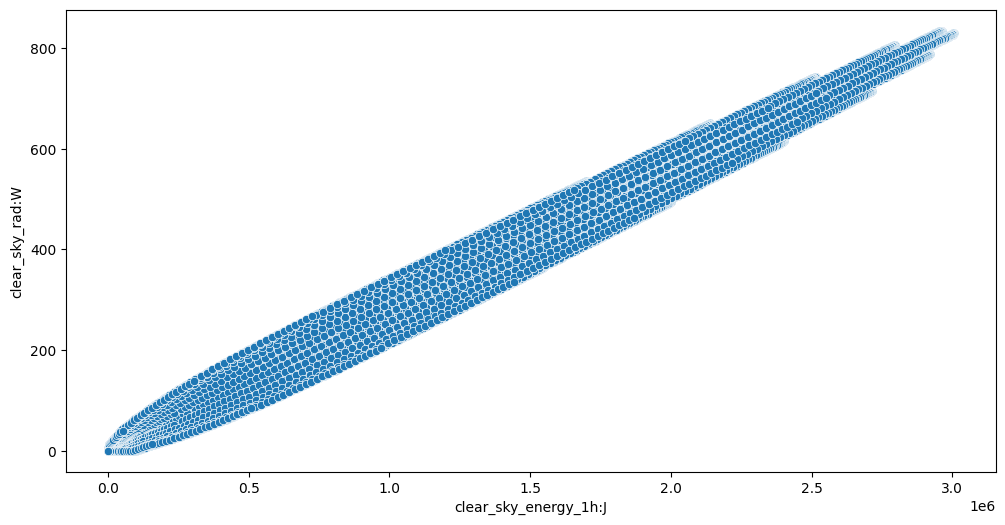

In [683]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='clear_sky_energy_1h:J', y='clear_sky_rad:W', data=df_A)

Highly Interdependent Features:
pressure_50m:hPa, sfc_pressure:hPa, and pressure_100m:hPa: These features have correlations very close to 1, indicating they are almost identical. One or two of these could likely be removed without losing much information.

dew_point_2m:K and absolute_humidity_2m:gm3: have a correlation of approximately 0.97, these variables are highly interrelated, suggesting redundancy. It also suggest that the correlation between them is linear. Let's see that in a plot.

Weather and Time-related Features:
fresh_snow_24h:cm, fresh_snow_12h:cm, fresh_snow_6h:cm, fresh_snow_3h:cm, and fresh_snow_1h:cm: These features are highly correlated with each other, ranging from 0.78 to 0.95, indicating they carry similar information about snowfall over different time periods.

solar_zenith_angle:d and sun_elevation:d: These features have a high negative correlation of -0.99, which makes sense because as the sun rises, the solar zenith angle decreases.

Correlations with Target Variable (pv_measurement):
clear_sky_energy_1h:J: This feature has a high positive correlation of 0.78 with the target variable 'pv_measurement', signifying its importance in predicting the target.

sun_elevation:d: This feature also shows a high positive correlation of 0.76 with the target variable, indicating its relevance in predicting solar energy production.

Other Interesting Correlations:
air_density_2m:kgm3 and t_1000hPa:K: These features have a high negative correlation of -0.91, which is logical given the inverse relationship between air density and temperature.

## 3.3 Non-linear Correlations

In [684]:
# Print a list of features pairs and their correlation from highest to lowest
corr_pairs = corr.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]
strong_pairs = strong_pairs[strong_pairs < 1]
strong_pairs = strong_pairs.drop_duplicates()
strong_pairs

t_1000hPa:K               air_density_2m:kgm3           -0.914536
air_density_2m:kgm3       dew_point_2m:K                -0.844157
                          absolute_humidity_2m:gm3      -0.810686
visibility:m              relative_humidity_1000hPa:p   -0.641664
                          effective_cloud_cover:p       -0.505436
direct_rad:W              diffuse_rad_1h:J               0.566275
diffuse_rad:W             direct_rad:W                   0.566684
direct_rad_1h:J           diffuse_rad:W                  0.570769
                          diffuse_rad_1h:J               0.575267
fresh_snow_6h:cm          fresh_snow_1h:cm               0.605707
fresh_snow_24h:cm         fresh_snow_6h:cm               0.605807
sun_elevation:d           direct_rad:W                   0.607562
                          direct_rad_1h:J                0.609721
fresh_snow_3h:cm          fresh_snow_12h:cm              0.628542
cloud_base_agl:m          ceiling_height_agl:m           0.630721
pv_measure

<Axes: xlabel='dew_point_2m:K', ylabel='absolute_humidity_2m:gm3'>

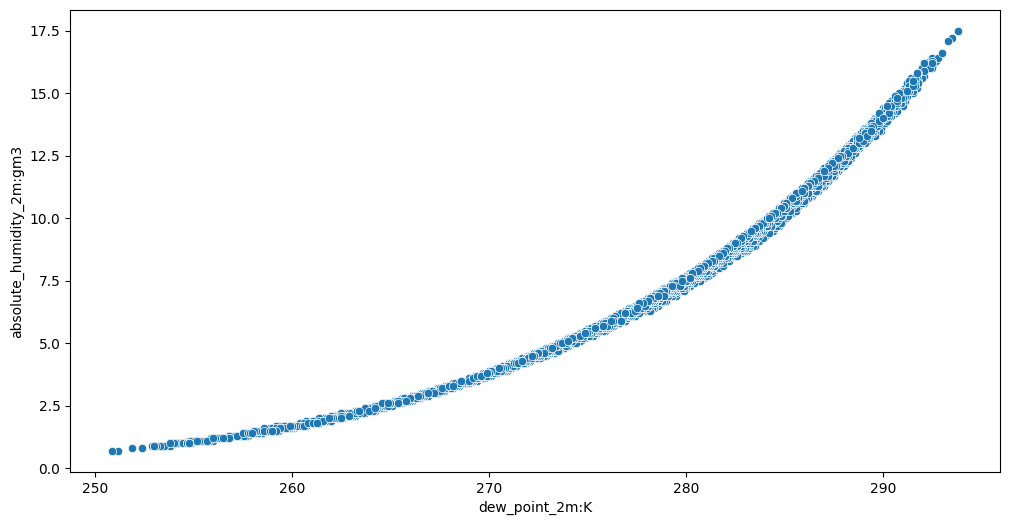

In [685]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dew_point_2m:K', y='absolute_humidity_2m:gm3', data=df_A)

<Axes: xlabel='visibility:m', ylabel='effective_cloud_cover:p'>

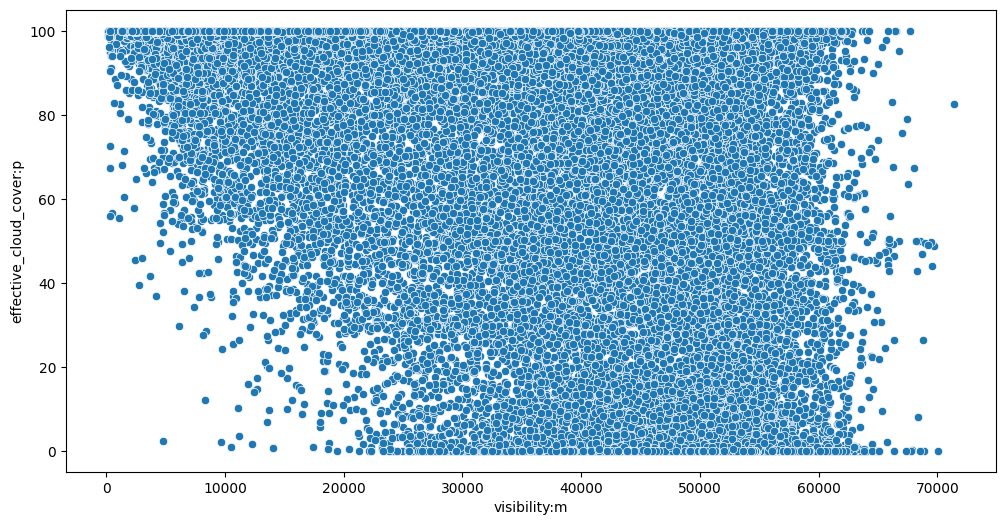

In [686]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='visibility:m', y='effective_cloud_cover:p', data=df_A)

Highly Interdependent Features:
pressure_50m:hPa, sfc_pressure:hPa, and pressure_100m:hPa: These features have near-perfect Spearman correlations, suggesting they convey almost identical information. Consider dropping some to remove redundancy.

dew_point_2m:K and absolute_humidity_2m:gm3: With a Spearman correlation of around 0.97, these features are highly associated and possibly redundant.

clear_sky_energy_1h:J and clear_sky_rad:W: These have a Spearman correlation of around 0.99, further confirming their redundancy.

Weather and Time-related Features:
fresh_snow_24h:cm, fresh_snow_12h:cm, fresh_snow_6h:cm, fresh_snow_3h:cm, and fresh_snow_1h:cm: These features show high Spearman correlations ranging from 0.75 to 0.94, indicating they are capturing similar snowfall patterns over different time frames.

solar_zenith_angle:d and sun_elevation:d: Their Spearman correlation is -0.99, which is in line with their natural inverse relationship.

Correlations with Target Variable (pv_measurement):
    clear_sky_energy_1h:J: This has a Spearman correlation of 0.78 with the target variable, emphasizing its importance for prediction.

sun_elevation:d: This feature also has a Spearman correlation of 0.76 with the target variable, underlining its significance.

Other Interesting Correlations:
air_density_2m:kgm3 and t_1000hPa:K: These features have a Spearman correlation of -0.91, suggesting a robust inverse relationship even when accounting for non-linearities.

## 3.4 Correlations Based on Dataset

## 3.5 First Feature Extraction Based on Feature Redundancy

# 4 In-depth Feature Information

## 4.1 Feature Extraction for Further EDA

In [687]:
# Prepare the data
X = df.drop(columns=['pv_measurement', 'time'])  # Drop the index, target, and time columns
y = df['pv_measurement']  # Target variable

## 4.2 Seasonal Decomposition

## 4.3 Stationarity 

## 4.4 Autocorrelation (ACF/PACF)

# Location B

In [721]:
train_targets_B = pd.read_parquet('./data/B/train_targets.parquet')
X_test_estimated_B = pd.read_parquet('./data/B/X_test_estimated.parquet')
X_train_estimated_B = pd.read_parquet('./data/B/X_train_estimated.parquet')
X_train_observed_B = pd.read_parquet('./data/B/X_train_observed.parquet')

In [722]:
df_B = pd.concat([X_train_observed_B, X_train_estimated_B])

In [723]:
df_B = pd.merge(df_B, train_targets_B, left_on='date_forecast', right_on='time', how='inner')

## Quality Check

Let's get an idea of where the missing values are

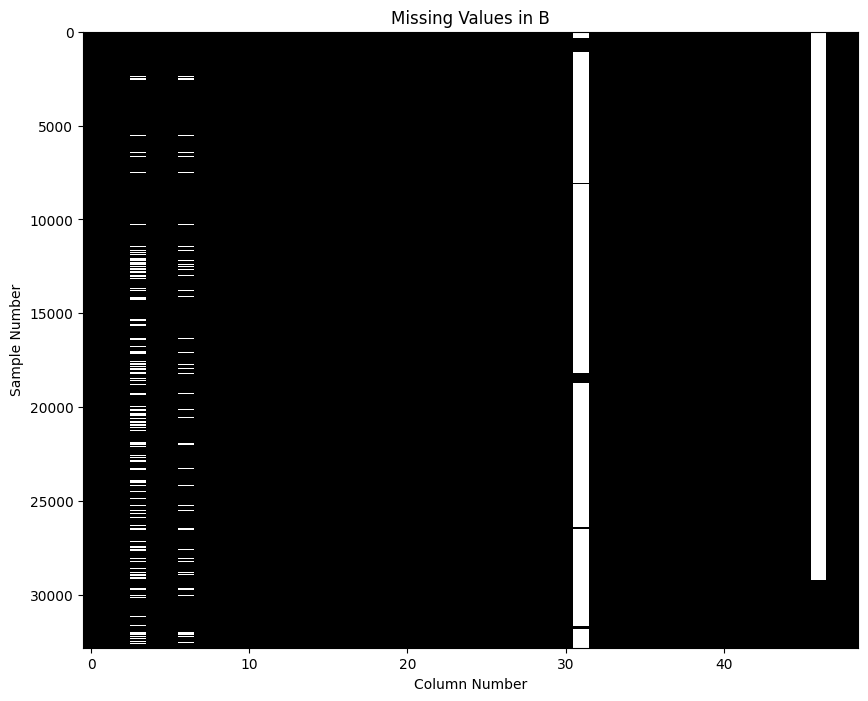

In [724]:
plt.figure(figsize=(10, 8))
plt.imshow(df_B.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")
plt.title("Missing Values in B")
plt.show()

From the figure above we can observe that there are at least 4 features that have many missing values. The two to to the right do not have as many missing values as the two to the left. But all four of these features have so many missing values that they should be dropped. We can take a closer look on exactly which features these are.

In [709]:
df_B.isna().sum()

date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               6475
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   2731
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0
precip_type_5min:idx                  0


In [710]:
missing_values = df_B.isna().sum()
missing_values = missing_values[missing_values > 0]
print(f'Number of features with missing values: {missing_values.shape[0]}')
print(f'Number of missing values per feature:')
print(missing_values)

Number of features with missing values: 5
Number of missing values per feature:
ceiling_height_agl:m     6475
cloud_base_agl:m         2731
snow_density:kgm3       31226
date_calc               29222
pv_measurement              4
dtype: int64


In [711]:
df_B = df_B.drop(columns=['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3'], axis=1)
df_B = df_B.drop(columns=['date_calc'], axis=0)

In [719]:
missing_values = df_B.isna().sum()
missing_values = missing_values[missing_values > 0]
print(f'Number of missing values per feature:')
print(missing_values)

Number of missing values per feature:
pv_measurement    4
dtype: int64


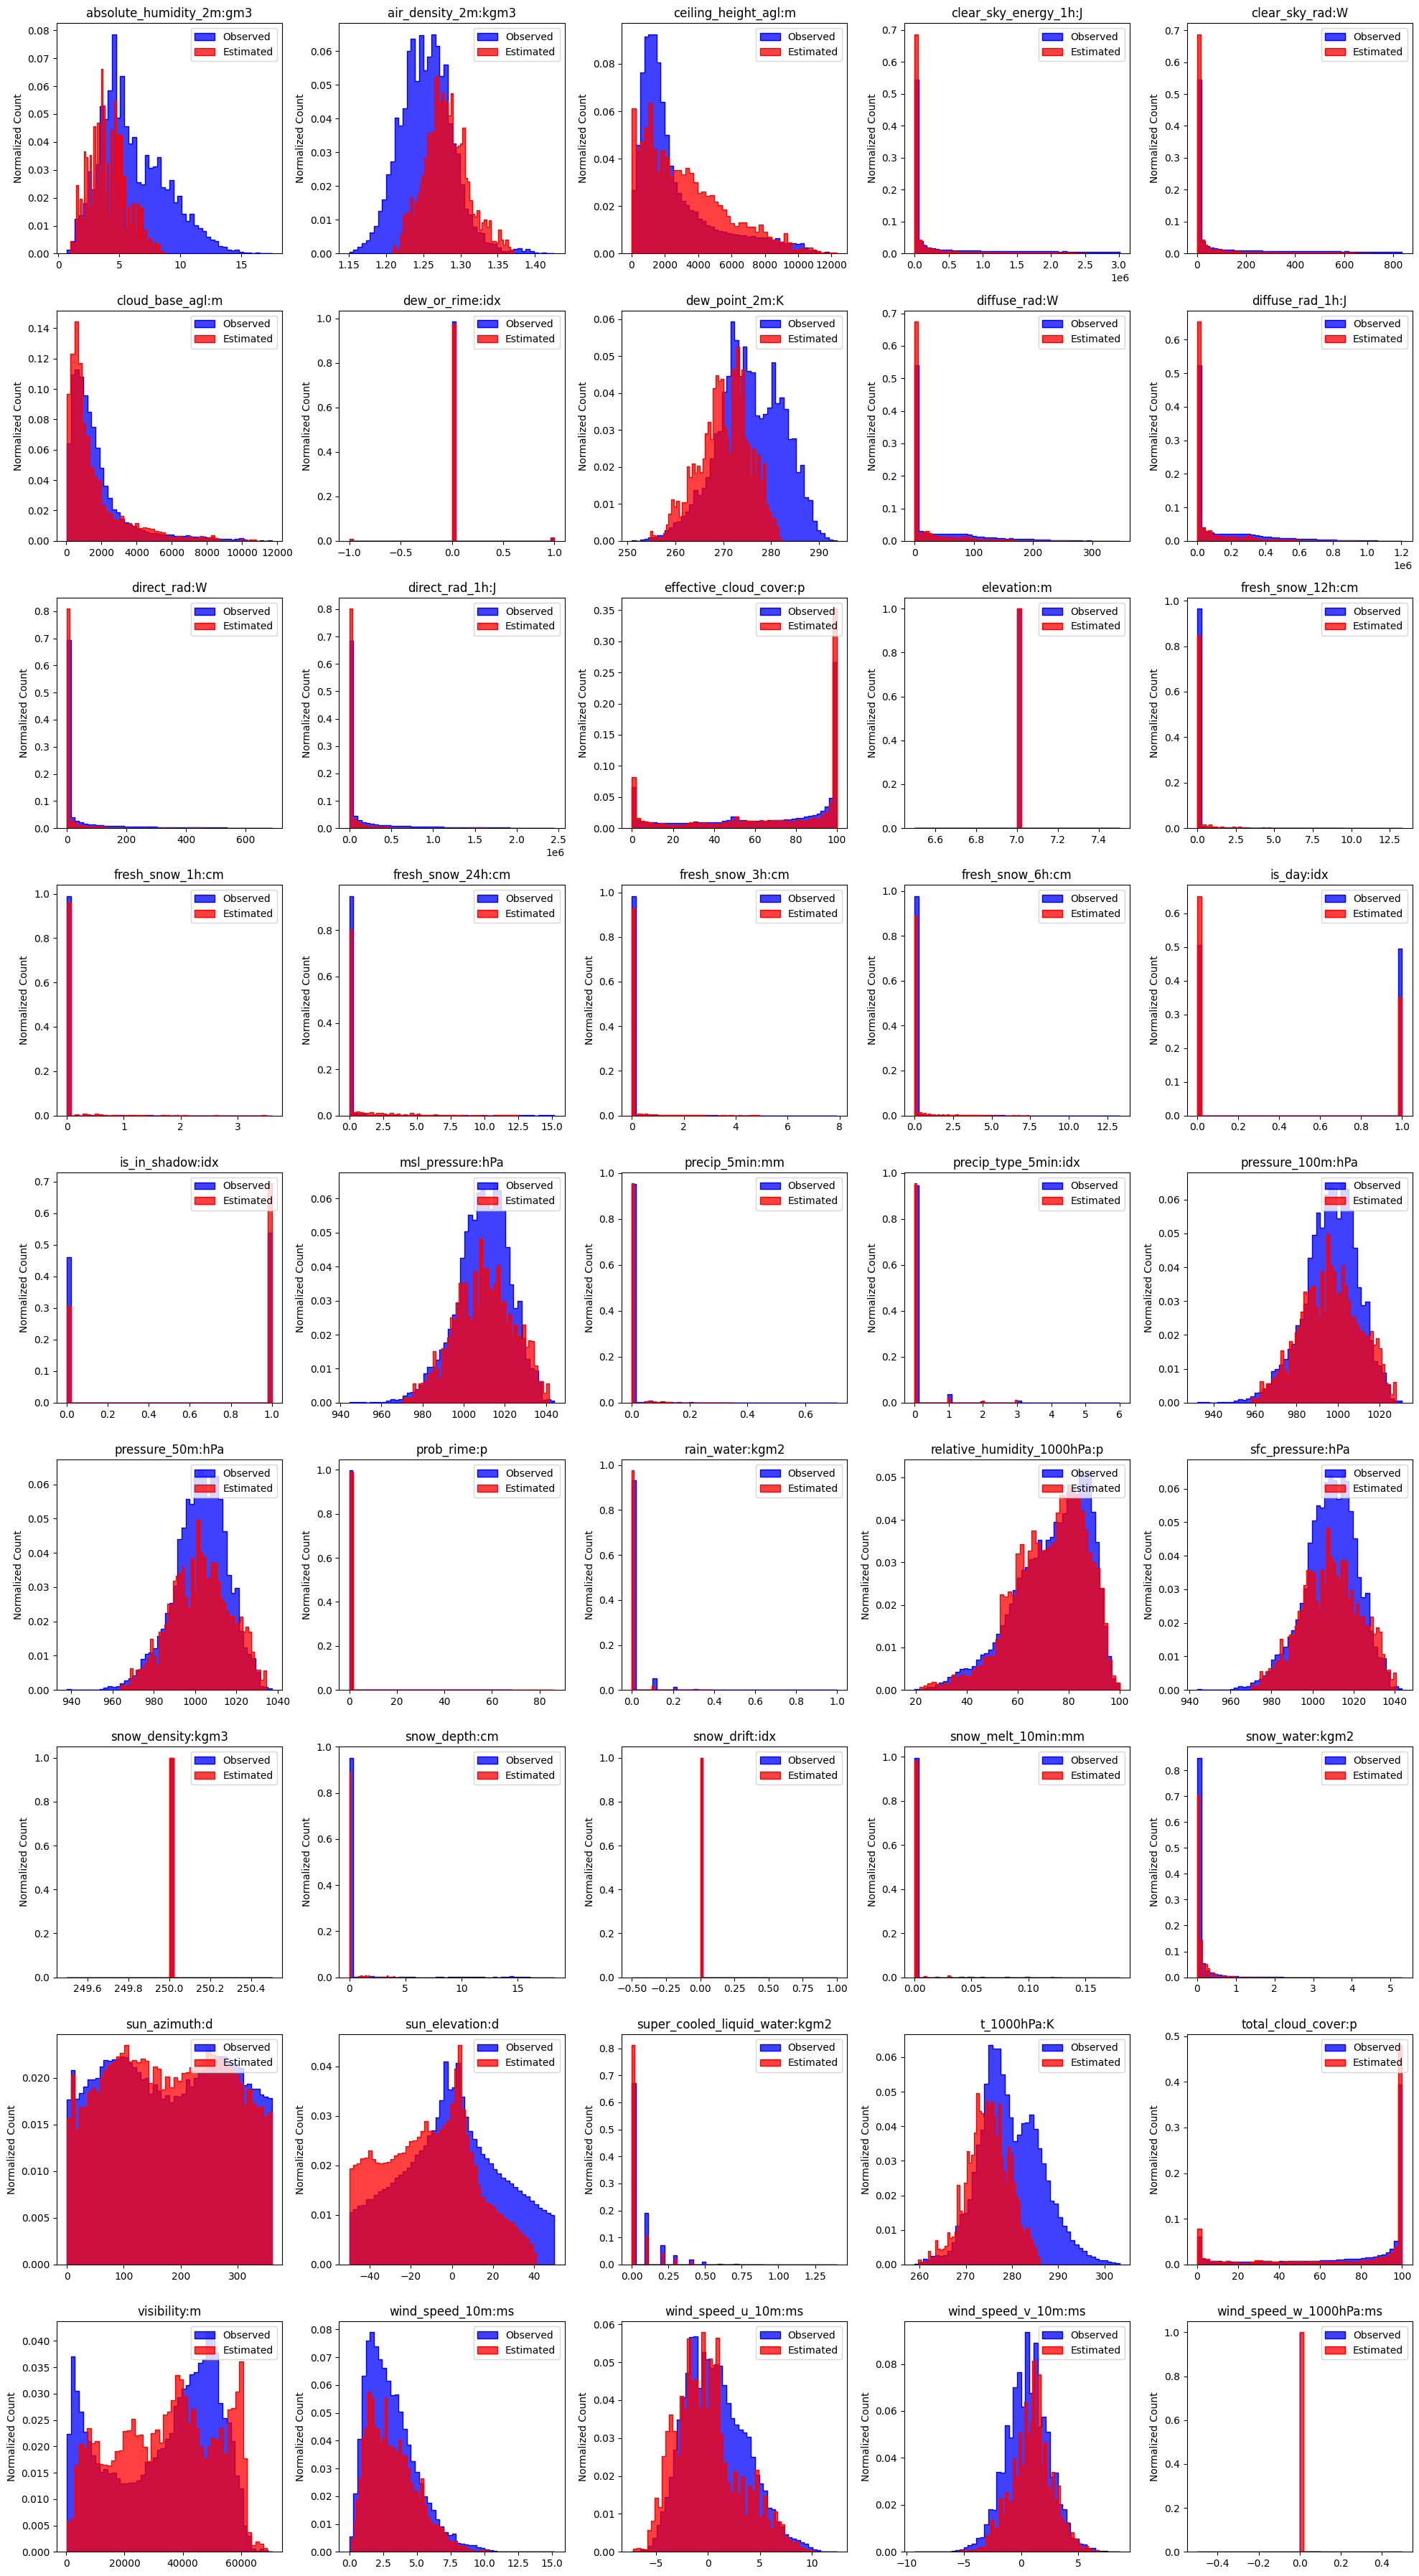

In [693]:
# Drop the index and target variable columns for feature distribution analysis
X_observed_B = X_train_observed_B.drop(columns=['date_forecast'])
X_estimated_B = X_train_estimated_B.drop(columns=['date_forecast'])
def plot_grid_feature_distributions(observed_df, estimated_df):
    features = observed_df.columns
    num_features = len(features)
    num_rows = -(-num_features // 5)  # Calculate rows needed, rounding up
    
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))
    axes = axes.flatten()  # Flatten the 2D array to 1D
    
    for i, feature in enumerate(features):
        ax = axes[i]
        sns.histplot(observed_df[feature], kde=False, bins=50, color='b', label='Observed', stat='probability', ax=ax, element='step')
        sns.histplot(estimated_df[feature], kde=False, bins=50, color='r', label='Estimated', stat='probability', ax=ax, element='step')
        ax.set_title(f'{feature}')
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Count')
        ax.legend()
    
    # Remove extra subplots
    for i in range(num_features, num_rows * 5):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the grid
plot_grid_feature_distributions(X_observed_B, X_estimated_B)

In [694]:
cols_continuous = df_B.select_dtypes(include="number").nunique() >= 25
df_continuous = df_B[cols_continuous[cols_continuous].index]

# Find linear correlations between features and plot them
corr = df_continuous.corr()
corr.style.background_gradient(cmap='coolwarm')

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,msl_pressure:hPa,precip_5min:mm,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,pv_measurement
absolute_humidity_2m:gm3,1.000000,-0.800621,0.052603,0.351595,0.349304,0.022355,0.973842,0.272663,0.277772,0.243364,0.246783,0.028215,-0.137480,-0.084373,-0.161188,-0.103142,-0.118290,0.129364,0.070396,0.149631,0.139221,-0.027145,0.167771,0.128901,-0.208703,0.041928,0.022151,0.403516,0.900097,0.049910,-0.210292,-0.112315,0.096681,-0.208826,0.323513
air_density_2m:kgm3,-0.800621,1.000000,-0.126527,-0.423204,-0.411728,-0.115910,-0.830605,-0.350109,-0.363312,-0.333045,-0.348363,-0.095140,0.080900,0.053528,0.099151,0.064111,0.071613,0.332771,-0.091448,0.311714,0.322874,0.029542,0.087012,0.333884,0.226304,-0.078473,-0.066697,-0.427280,-0.900440,-0.125581,0.060621,-0.063581,-0.014495,0.097650,-0.367909
ceiling_height_agl:m,0.052603,-0.126527,1.000000,0.101948,0.094427,0.704230,0.045783,0.106276,0.110929,0.250937,0.261758,-0.286247,-0.025166,-0.019089,-0.029009,-0.024046,-0.025215,0.064063,0.007491,0.068260,0.066448,-0.014378,-0.383561,0.064683,-0.098177,-0.168317,0.054521,0.084468,0.206118,0.031934,0.402803,-0.130228,-0.275705,0.016870,0.156788
clear_sky_energy_1h:J,0.351595,-0.423204,0.101948,1.000000,0.992308,0.104945,0.352191,0.912142,0.921867,0.742438,0.752181,-0.025548,-0.070324,-0.049708,-0.082297,-0.059769,-0.064860,0.145503,-0.008005,0.155140,0.149257,-0.028630,-0.336970,0.143380,-0.091408,-0.038956,0.036227,0.828135,0.437093,-0.017461,0.025849,0.005471,0.059636,-0.317805,0.778166
clear_sky_rad:W,0.349304,-0.411728,0.094427,0.992308,1.000000,0.099990,0.349610,0.918580,0.914404,0.749177,0.747313,-0.024698,-0.068927,-0.048979,-0.082039,-0.058351,-0.063333,0.146116,-0.008568,0.155475,0.149733,-0.028142,-0.311553,0.144001,-0.091079,-0.039501,-0.013907,0.831643,0.423041,-0.017044,0.016796,-0.004667,0.054952,-0.304633,0.797163
cloud_base_agl:m,0.022355,-0.115910,0.704230,0.104945,0.099990,1.000000,0.012574,0.083368,0.088657,0.258541,0.267177,-0.305372,-0.027936,-0.020333,-0.027407,-0.024581,-0.028058,0.054730,-0.022015,0.058914,0.057161,-0.000330,-0.454848,0.055468,-0.051209,-0.125405,0.045981,0.079119,0.199400,-0.077204,0.428813,-0.168339,-0.343295,0.039078,0.191939
dew_point_2m:K,0.973842,-0.830605,0.045783,0.352191,0.349610,0.012574,1.000000,0.278395,0.283778,0.239151,0.242945,0.073612,-0.143382,-0.090102,-0.168225,-0.109219,-0.124396,0.122465,0.071871,0.143339,0.132559,-0.024792,0.174984,0.121866,-0.263793,0.060794,0.025130,0.404261,0.913567,0.091755,-0.248910,-0.065434,0.143359,-0.193474,0.323798
diffuse_rad:W,0.272663,-0.350109,0.106276,0.912142,0.918580,0.083368,0.278395,1.000000,0.988926,0.579081,0.581600,0.047477,-0.054008,-0.046726,-0.062993,-0.053276,-0.054167,0.119069,-0.018863,0.126761,0.121898,-0.028246,-0.300058,0.117040,-0.076096,-0.080636,-0.013217,0.803002,0.342400,0.066222,0.043526,-0.002308,0.054201,-0.279270,0.683735
diffuse_rad_1h:J,0.277772,-0.363312,0.110929,0.921867,0.914404,0.088657,0.283778,0.988926,1.000000,0.579107,0.587058,0.043564,-0.056702,-0.048139,-0.063906,-0.056025,-0.057100,0.119665,-0.018268,0.127673,0.122644,-0.029486,-0.324943,0.117618,-0.077090,-0.075879,0.038390,0.803332,0.357549,0.060888,0.050771,0.006061,0.058019,-0.293764,0.672463
direct_rad:W,0.243364,-0.333045,0.250937,0.742438,0.749177,0.258541,0.239151,0.579081,0.579107,1.000000,0.988261,-0.334532,-0.055865,-0.037838,-0.065915,-0.045569,-0.049947,0.180685,-0.053249,0.188929,0.183962,-0.019925,-0.452556,0.179018,-0.066418,-0.146370,-0.

In [695]:
# find which features correlations are the same and in both df_A and df_B
corr_pairs = corr.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]
strong_pairs = strong_pairs[strong_pairs < 1]
strong_pairs = strong_pairs.drop_duplicates()
strong_pairs

t_1000hPa:K                  air_density_2m:kgm3        -0.900440
air_density_2m:kgm3          dew_point_2m:K             -0.830605
absolute_humidity_2m:gm3     air_density_2m:kgm3        -0.800621
relative_humidity_1000hPa:p  visibility:m               -0.608931
visibility:m                 effective_cloud_cover:p    -0.507642
wind_speed_u_10m:ms          visibility:m               -0.500074
                             wind_speed_10m:ms           0.500842
fresh_snow_3h:cm             fresh_snow_24h:cm           0.533211
diffuse_rad:W                direct_rad:W                0.579081
diffuse_rad_1h:J             direct_rad:W                0.579107
direct_rad_1h:J              diffuse_rad:W               0.581600
                             diffuse_rad_1h:J            0.587058
direct_rad:W                 sun_elevation:d             0.611567
sun_elevation:d              direct_rad_1h:J             0.613062
fresh_snow_1h:cm             fresh_snow_6h:cm            0.621143
pv_measure

# Location C

In [696]:
train_targets_C = pd.read_parquet('./data/C/train_targets.parquet')
X_test_estimated_C = pd.read_parquet('./data/C/X_test_estimated.parquet')
X_train_estimated_C = pd.read_parquet('./data/C/X_train_estimated.parquet')
X_train_observed_C = pd.read_parquet('./data/C/X_train_observed.parquet')

In [697]:
df_C = pd.concat([X_train_observed_C, X_train_estimated_C])

In [698]:
df_C = pd.merge(df_C, train_targets, left_on='date_forecast', right_on='time', how='inner')

In [699]:
df_C.isna().sum()

date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               6951
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   3066
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0
precip_type_5min:idx                  0


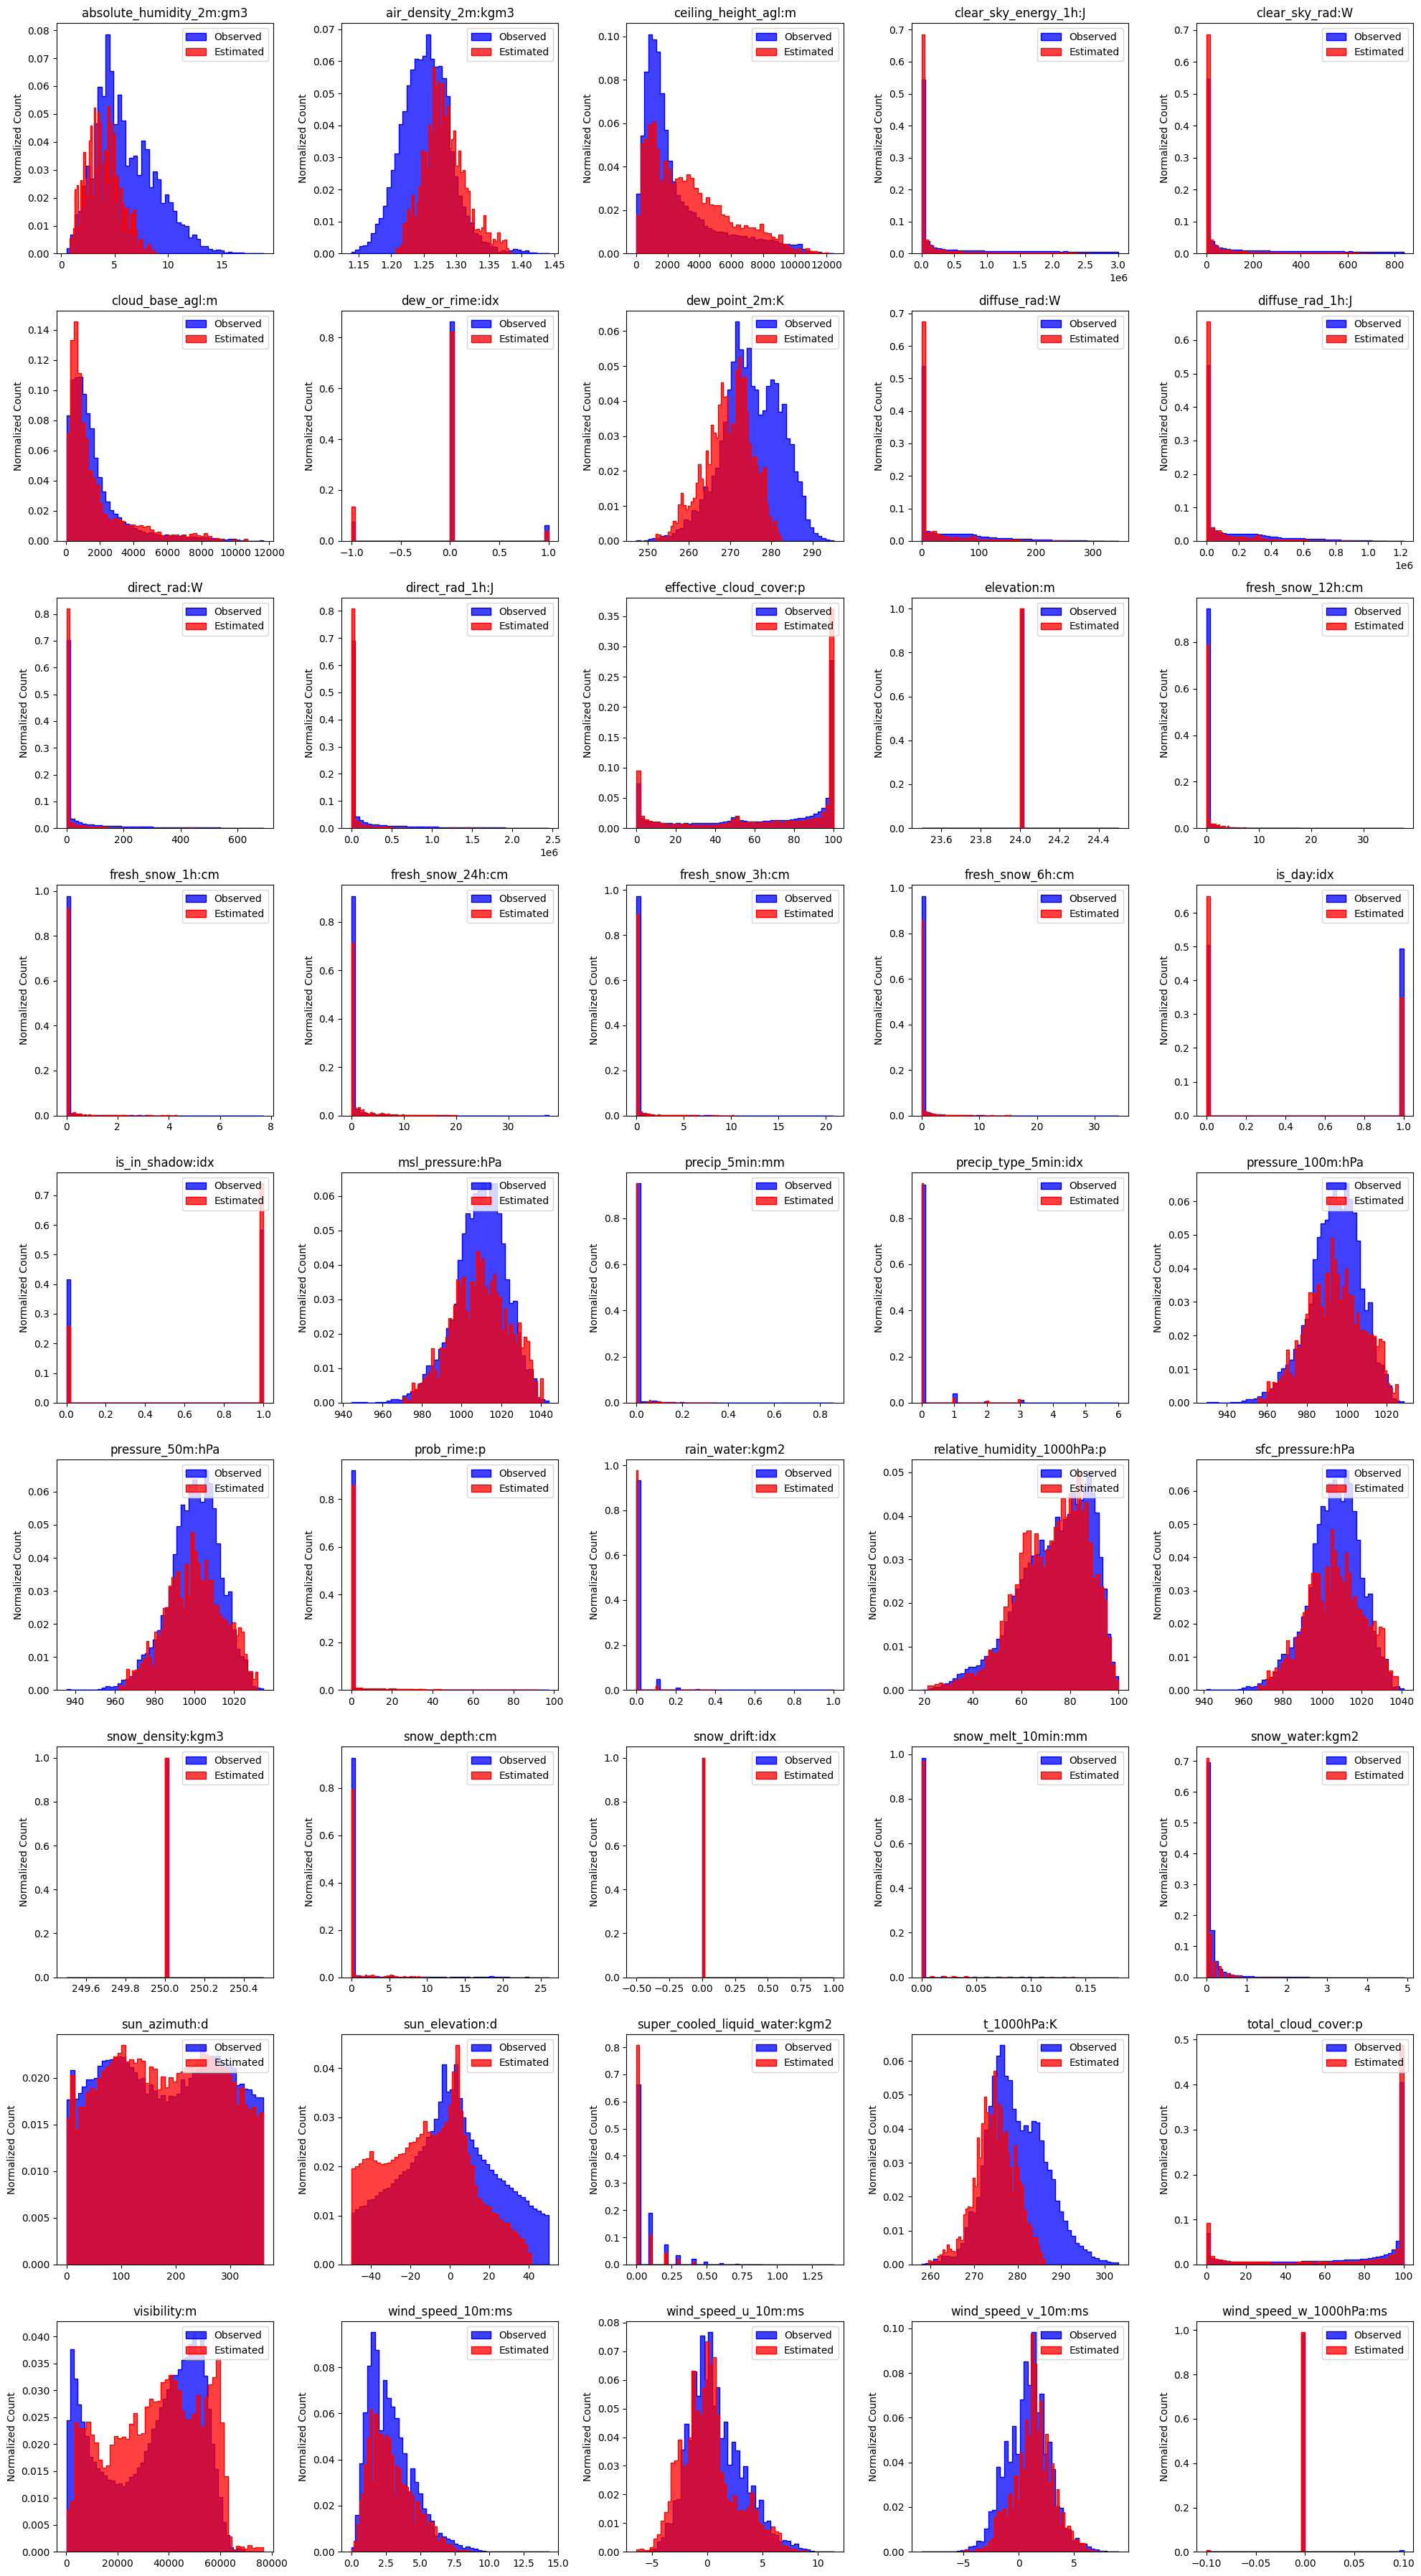

In [700]:
# Drop the index and target variable columns for feature distribution analysis
X_observed_C = X_train_observed_C.drop(columns=['date_forecast'])
X_estimated_C = X_train_estimated_C.drop(columns=['date_forecast'])
def plot_grid_feature_distributions(observed_df, estimated_df):
    features = observed_df.columns
    num_features = len(features)
    num_rows = -(-num_features // 5)  # Calculate rows needed, rounding up
    
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))
    axes = axes.flatten()  # Flatten the 2D array to 1D
    
    for i, feature in enumerate(features):
        ax = axes[i]
        sns.histplot(observed_df[feature], kde=False, bins=50, color='b', label='Observed', stat='probability', ax=ax, element='step')
        sns.histplot(estimated_df[feature], kde=False, bins=50, color='r', label='Estimated', stat='probability', ax=ax, element='step')
        ax.set_title(f'{feature}')
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Count')
        ax.legend()
    
    # Remove extra subplots
    for i in range(num_features, num_rows * 5):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the grid
plot_grid_feature_distributions(X_observed_C, X_estimated_C)

# 5. Feature Engineering

## 5.1 Time based Features

In [701]:
def date_features(df):
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.dayofyear
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['quarter'] = pd.to_datetime(df['time']).dt.quarter

    df['lagged_pv_measurement_1h'] = df['pv_measurement'].shift(1)
    df['lagged_pv_measurement_3h'] = df['pv_measurement'].shift(3)
    df['lagged_pv_measurement_6h'] = df['pv_measurement'].shift(6)

    df['rolling_mean_pv_measurement_3h'] = df['pv_measurement'].rolling(window=3).mean()
    return df

date_features(df)

,Unnamed: 0,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,pv_measurement,location,hour,day,month,quarter,lagged_pv_measurement_1h,lagged_pv_measurement_3h,lagged_pv_measurement_6h,rolling_mean_pv_measurement_3h
0,0,7.7,1.230,1744.9,0.0,0.0,1744.9,0.0,280.3,0.0,...,0.00,A,22,153,6,2,NaN,NaN,NaN,NaN
1,1,7.7,1.225,1703.6,0.0,0.0,1703.6,0.0,280.3,0.0,...,0.00,A,23,153,6,2,0.00,NaN,NaN,NaN
2,2,7.7,1.221,1668.1,0.0,0.0,1668.1,0.0,280.2,0.0,...,0.00,A,0,154,6,2,0.00,NaN,NaN,0.000000
3,3,8.2,1.218,1388.4,0.0,0.0,1388.4,0.0,281.3,0.0,...,0.00,A,1,154,6,2,0.00,0.00,NaN,0.000000
4,4,8.8,1.219,1108.5,6546.9,9.8,1108.5,0.0,282.3,4.3,...,19.36,A,2,154,6,2,0.00,0.00,NaN,6.453333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99009,32125,4.4,1.274,1474.2,156770.7,13.4,557.0,0.0,272.1,8.8,...,50.96,C,19,120,4,2,175.42,125.44,476.28,138.833333
99010,32126,4.4,1.278,1427.3,7917.1,0.0,541.7,0.0,272.0,0.0,...,2.94,C,20,120,4,2,50.96,190.12,491.96,76.440000
99011,32127,4.4,1.279,1558.1,0.0,0.0,601.5,0.0,271.9,0.0,...,0.00,C,21,120,4,2,2.94,175.42,267.54,17.966667
99012,32128,4.4,1.279,1446.6,0.0,0.0,540.7,0.0,271.9,0.0,...,-0.00,C,22,120,4,2,0.00,50.96,125.44,0.980000


In [702]:
# Make sure to have a column 'id' for each time series and 'time' for the time stamps
# extracted_features = extract_features(df, column_id='id', column_sort='time')